# Project - Modeling Complex Genomic Associations

# Introduction
Welcome to the project notebook where we will be exploring and modeling genomic data to understand cancer subtypes better. This notebook outlines the steps from data collection, preprocessing, exploratory analysis, to modeling using various machine learning techniques. Our goal is to identify patterns that distinguish different cancer subtypes and predict them accurately.



### Import Libraries
Here we import all necessary Python packages that are required throughout this notebook. This includes libraries for data manipulation, data visualization, machine learning, and metrics evaluation.


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import  xgboost as xgb
from sklearn.preprocessing import LabelEncoder

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier


from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support


## Data Collection
We start by loading the dataset which will be used for the analysis. The data includes genomic expressions which might help in classifying cancer subtypes.


### Load 'data.csv' 

In [3]:
# Load tab-delimited text file into a DataFrame
data = pd.read_csv('data.csv')

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
data.head()

First few rows of the DataFrame:


,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


### Load 'labels.csv' 

In [4]:
# Load tab-delimited text file into a DataFrame
labels = pd.read_csv('labels.csv')

# Display the first few rows of the DataFrame
print("First few rows of the DataFrame:")
labels.head()

First few rows of the DataFrame:


,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [5]:
df = pd.merge(data, labels)
df.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


In [6]:
df.shape

(801, 20533)

#### Drop the instance label column

In [7]:
df = df.drop(df.columns[0], axis=1)
df.head()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530,Class
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0,PRAD
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0,LUAD
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0,PRAD
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0,PRAD
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0,BRCA


## Basic Exploratory Analysis

### Data Preprocessing
Before diving into exploratory data analysis and modeling, let's preprocess the data by removing any unwanted columns and checking for null values. This step ensures that the data fed into the model is clean and suitable for analysis.


In [8]:
#Checking the data type
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, Unnamed: 0 to gene_20530
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  801 non-null    object
 1   Class       801 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20532 entries, gene_0 to Class
dtypes: float64(20531), object(1)
memory usage: 125.5+ MB


### Further Data Checks
Perform basic data integrity checks such as data types and null value inspection to ensure the dataset is ready for analysis.


In [11]:
#Checking for null values
data.isnull().sum()


Unnamed: 0    0
gene_0        0
gene_1        0
gene_2        0
gene_3        0
             ..
gene_20526    0
gene_20527    0
gene_20528    0
gene_20529    0
gene_20530    0
Length: 20532, dtype: int64

In [12]:
# Summary statistics for the "Class" column
df['Class'].describe()

count      801
unique       5
top       BRCA
freq       300
Name: Class, dtype: object

## Exploratory Data Analysis (EDA)
We will now explore the data to understand its characteristics and distributions. This step is crucial as it helps uncover patterns, anomalies, and relationships in the data.


Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


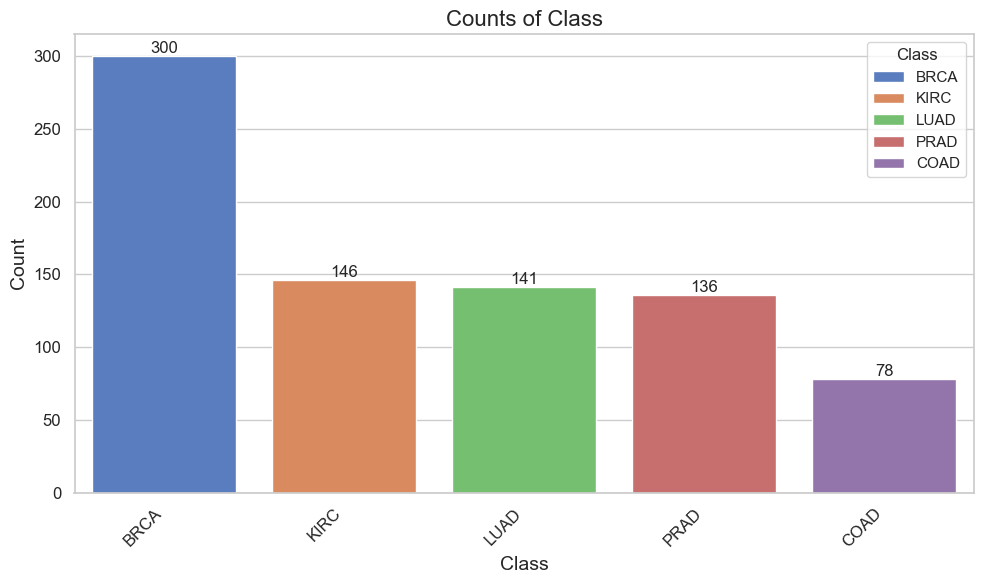

In [13]:
sns.set(style="whitegrid")
# Choose the column for which you want to plot the counts
column_name = 'Class'

# # Count the number of unique classes and their frequencies
# class_counts = labels['Class'].value_counts()
# print(class_counts)

# Get the value counts for the specified column
value_counts = df[column_name].value_counts()
print(value_counts)

palette = sns.color_palette("muted", len(value_counts))



# Plot the bar chart
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=value_counts.index, y=value_counts.values, hue=value_counts.index, palette=palette, dodge=False)

# Adding annotations
for index, value in enumerate(value_counts.values):
    barplot.text(index, value + 0.1, str(value), ha='center', va='bottom')

# Adding title and labels
plt.title(f'Counts of {column_name}', fontsize=16)
plt.xlabel(column_name, fontsize=14)
plt.ylabel('Count', fontsize=14)

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Adjusting layout
plt.tight_layout()

# Show plot
plt.show()

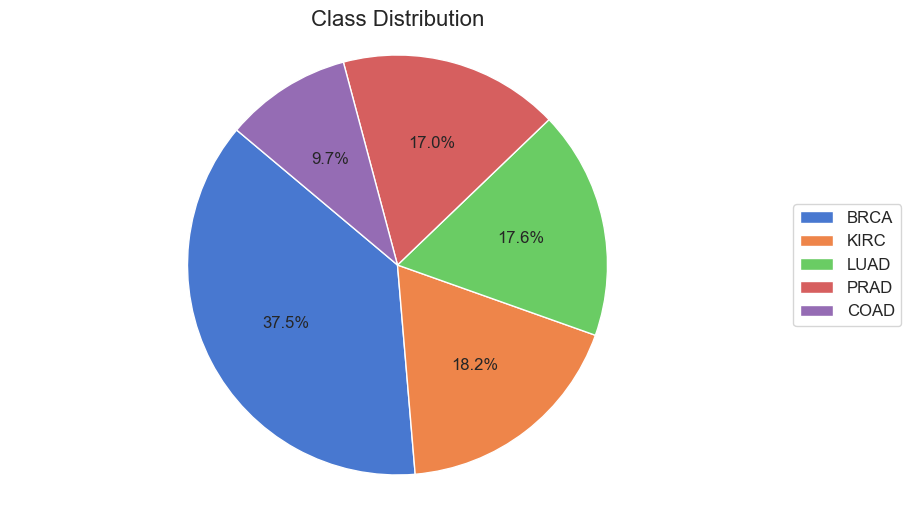

In [14]:
# Set the style
sns.set(style="whitegrid")

# Create a pie chart with the same color palette
plt.figure(figsize=(10, 6))
plt.pie(value_counts.values, labels=None, autopct='%1.1f%%', startangle=140, colors=palette)

# Add a legend with class names on the right
plt.legend(value_counts.index, loc="center left", fontsize=12, bbox_to_anchor=(1, 0.5))

# Add a title
plt.title(f'{column_name} Distribution', fontsize=16)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Show the plot
plt.show()

In [15]:
df.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


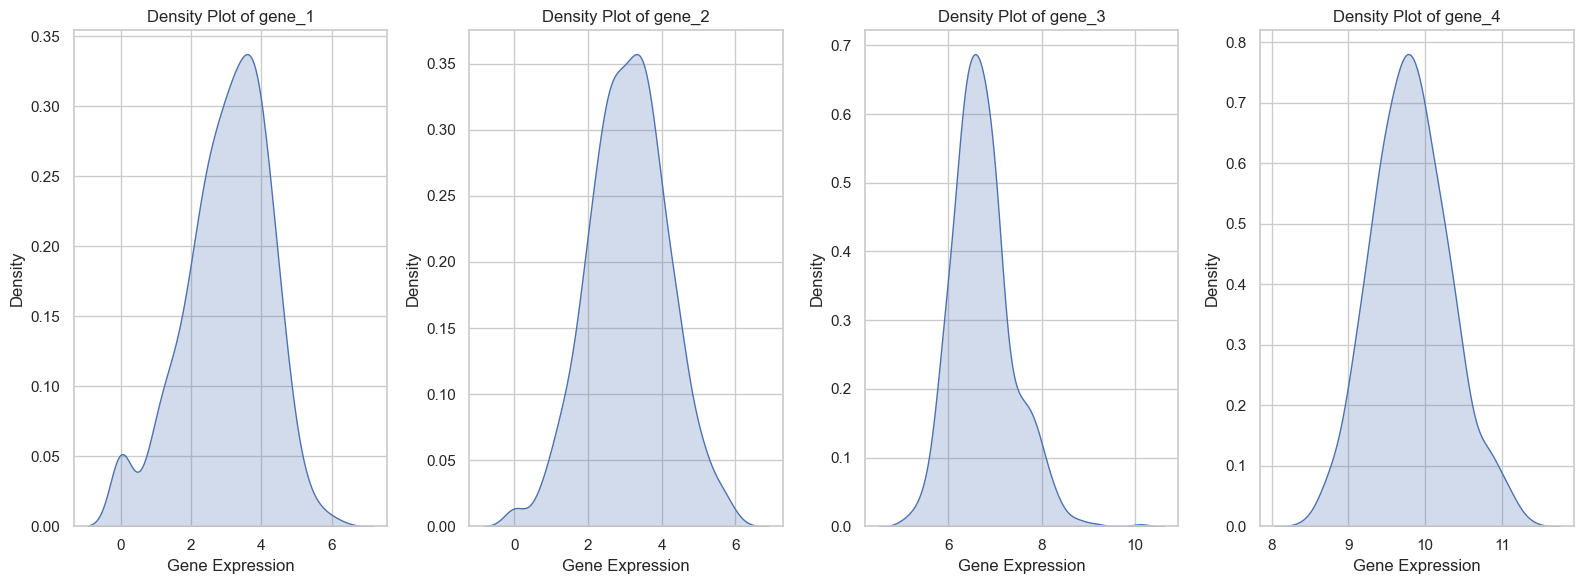

In [16]:
plt.figure(figsize=(16, 6))

# Density plot for gene_1
plt.subplot(1, 4, 1)
sns.kdeplot(data['gene_1'], fill=True)
plt.title('Density Plot of gene_1')
plt.xlabel('Gene Expression')
plt.ylabel('Density')

# Density plot for gene_2
plt.subplot(1, 4, 2)
sns.kdeplot(data['gene_2'], fill=True)
plt.title('Density Plot of gene_2')
plt.xlabel('Gene Expression')
plt.ylabel('Density')

# Density plot for gene_3
plt.subplot(1, 4, 3)
sns.kdeplot(data['gene_3'], fill=True)
plt.title('Density Plot of gene_3')
plt.xlabel('Gene Expression')
plt.ylabel('Density')

# Density plot for gene_4
plt.subplot(1, 4, 4)
sns.kdeplot(data['gene_4'], fill=True)
plt.title('Density Plot of gene_4')
plt.xlabel('Gene Expression')
plt.ylabel('Density')

plt.tight_layout()
plt.savefig('density_plots.png', dpi=300, bbox_inches='tight')
plt.show()

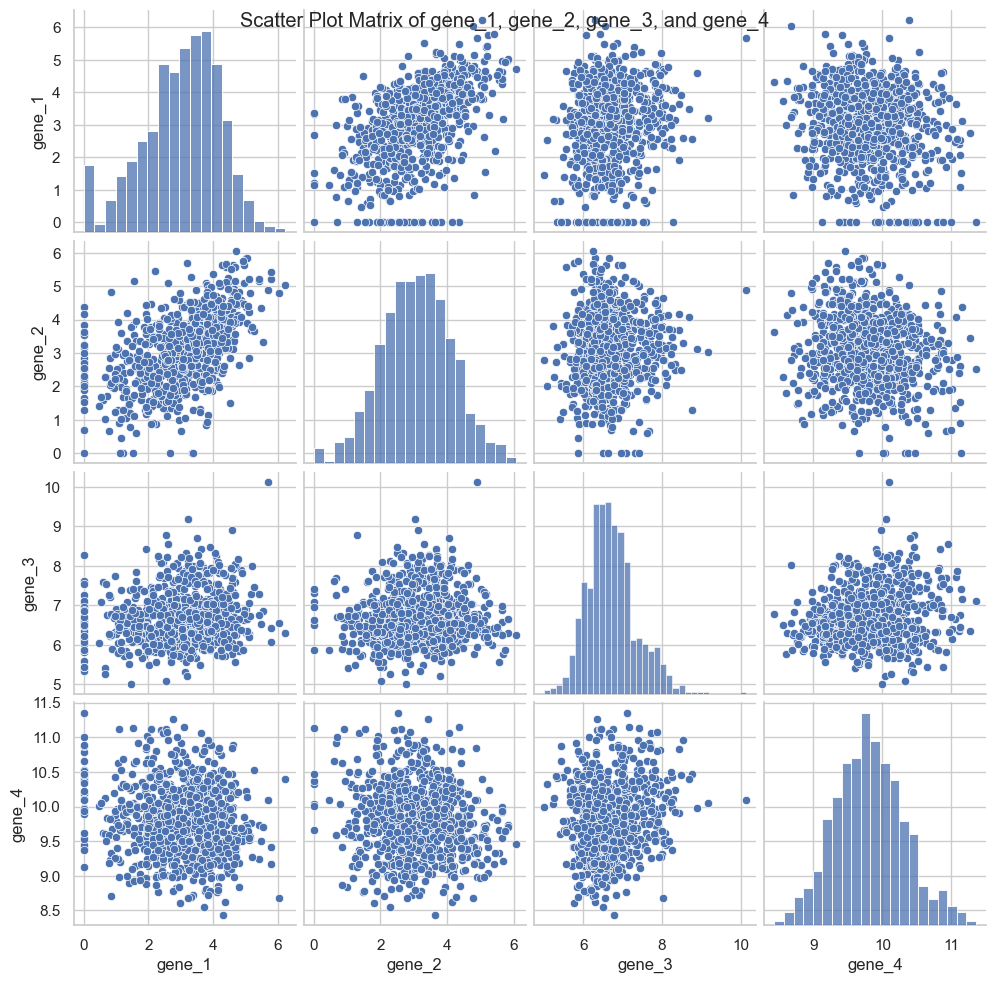

In [17]:
# Select only the genes you want to include in the scatter plot matrix
selected_genes = data[['gene_1', 'gene_2', 'gene_3', 'gene_4']]

# Create a pairplot for the selected genes
sns.pairplot(selected_genes)
plt.suptitle('Scatter Plot Matrix of gene_1, gene_2, gene_3, and gene_4')

# Save the figure
plt.savefig('scatter_plot_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## Feature Engineering and Dimensionality Reduction
To improve model performance and reduce computational complexity, we apply PCA for dimensionality reduction. This step helps in visualizing high-dimensional data and can also improve the clustering results.


In [18]:
# Dimesnionality Code

# print all columns except for the last and first column
print()
# print(data[1::])

In [19]:
from sklearn.manifold import Isomap

# Assuming 'data' is your full DataFrame containing the gene expression data
features = data[[c for c in data.columns if c not in ['Unnamed: 0', 'gene_0']]]  # using all available features

# Initialize the Isomap algorithm
iso = Isomap(n_components=2, n_neighbors=40, n_jobs=-1, eigen_solver='dense')  # or more components if you want to explore higher dimensional structure

# Fit the model and transform the data
reduced_data = iso.fit_transform(features)

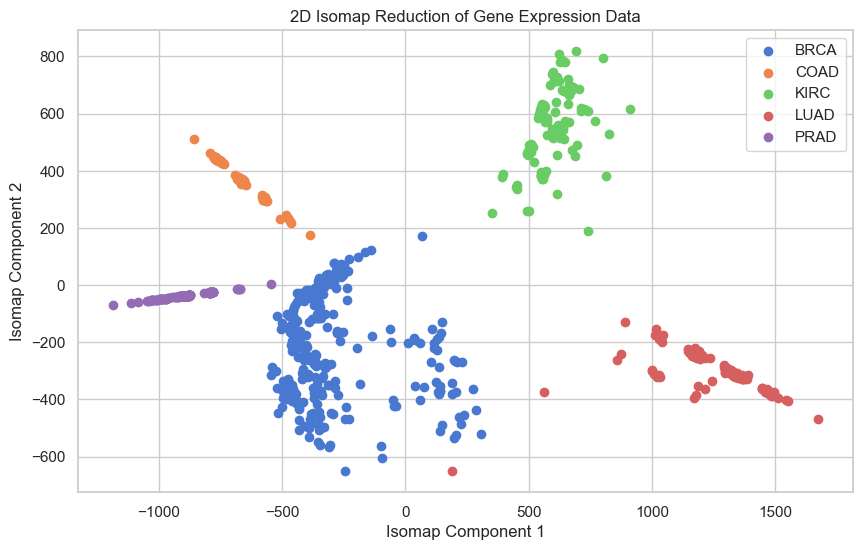

In [20]:

# Assuming 'data' is your full DataFrame containing the gene expression data
# Perform Isomap dimensionality reduction
iso = Isomap(n_components=2)
data_reduced = iso.fit_transform(features)

# Assuming 'class_labels' contains the class for each sample in 'data'
class_labels = labels['Class']  # Adjust as per your actual labels data

# Convert categorical labels to numerical labels
class_labels_unique = np.unique(class_labels)
class_labels_dict = {label: i for i, label in enumerate(class_labels_unique)}
numerical_labels = np.array([class_labels_dict[label] for label in class_labels])

# Create a colormap based on numerical labels
# cmap = plt.cm.get_cmap('viridis', len(class_labels_unique))
palette = sns.color_palette("muted", len(class_labels_unique))


# Create a scatter plot with different colors for each class
plt.figure(figsize=(10, 6))

# Loop through unique numerical class labels and plot each class with a different color
for i, label in enumerate(np.unique(numerical_labels)):
    indices = numerical_labels == label
    plt.scatter(
        data_reduced[indices, 0],
        data_reduced[indices, 1],
        c=palette[i],  # Map numerical label to color
        label=class_labels_unique[label],  # Label for the legend
    )

plt.title('2D Isomap Reduction of Gene Expression Data')
plt.xlabel('Isomap Component 1')
plt.ylabel('Isomap Component 2')

# Add a legend
plt.legend()

plt.grid(True)
plt.show()


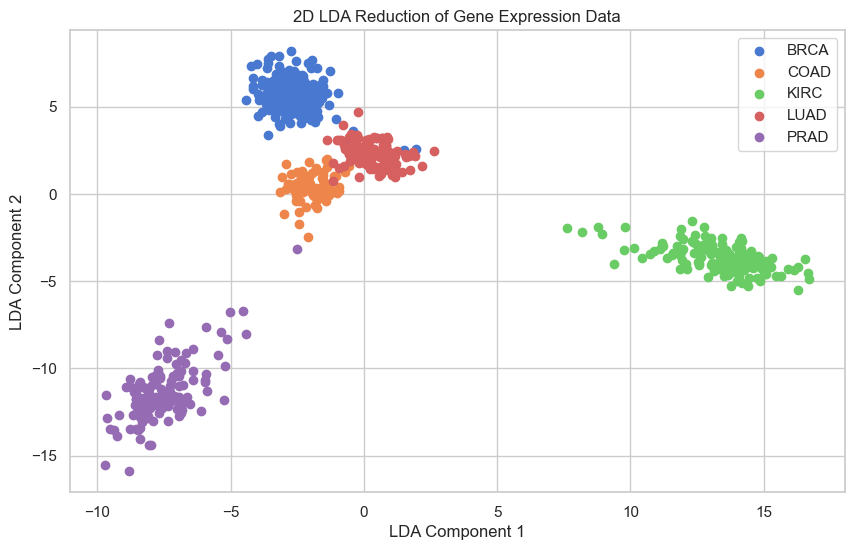

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Assuming 'data' is your full DataFrame containing the gene expression data
# and 'class_labels' contains the corresponding class for each sample

# Convert categorical labels to numerical labels if they are not already numerical
class_labels_unique = np.unique(class_labels)
class_labels_dict = {label: i for i, label in enumerate(class_labels_unique)}
numerical_labels = np.array([class_labels_dict[label] for label in class_labels])

# Initialize the LDA model
# The number of components for LDA is usually one less than the number of classes
# but here we set it to 2 for visualization purposes
lda = LDA(n_components=2)

# Fit the model and transform the data
data_reduced = lda.fit_transform(features, numerical_labels)

# Create a colormap based on numerical labels
# cmap = plt.cm.get_cmap('viridis', len(class_labels_unique))
palette = sns.color_palette("muted", len(class_labels_unique))

# Create a scatter plot with different colors for each class
plt.figure(figsize=(10, 6))

# Loop through unique numerical class labels and plot each class with a different color
for i, label in enumerate(np.unique(numerical_labels)):
    indices = numerical_labels == label
    plt.scatter(
        data_reduced[indices, 0],
        data_reduced[indices, 1],
        c=palette[i],  # Map numerical label to color
        label=class_labels_unique[label]  # Label for the legend
    )

plt.title('2D LDA Reduction of Gene Expression Data')
plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')

# Add a legend
plt.legend()

plt.grid(True)
plt.show()


## Analysis

#### Clustering Analysis

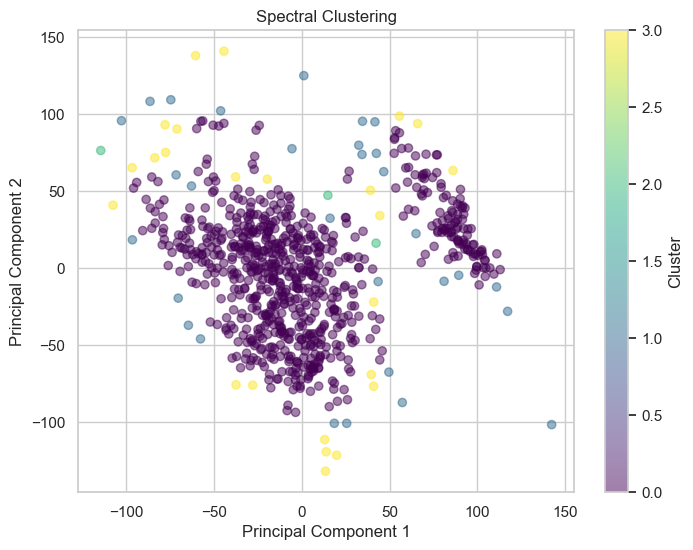

In [22]:
df_x = df.drop(columns=['Class'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_x)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

spectral = SpectralClustering(n_clusters=5, assign_labels='discretize', random_state=42)
clusters = spectral.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Spectral Clustering')
plt.colorbar(label='Cluster')
plt.show()


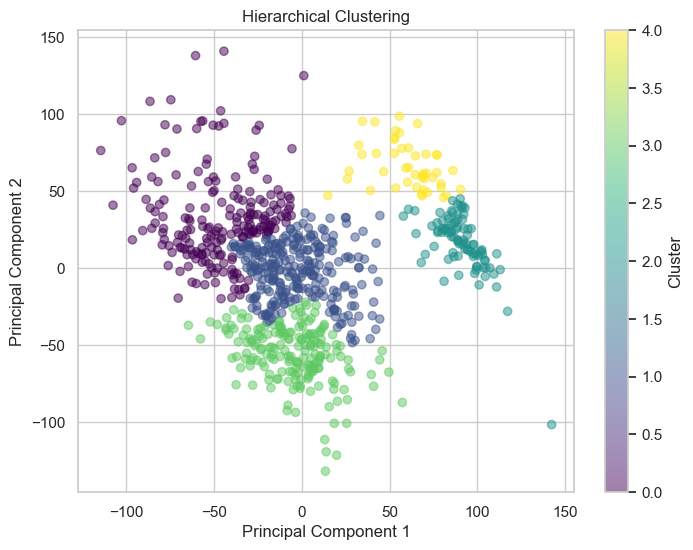

In [23]:
df_x = df.drop(columns=['Class'])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_x)

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

hierarchical = AgglomerativeClustering(n_clusters=5)
clusters = hierarchical.fit_predict(X_pca)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Hierarchical Clustering')
plt.colorbar(label='Cluster')
plt.show()

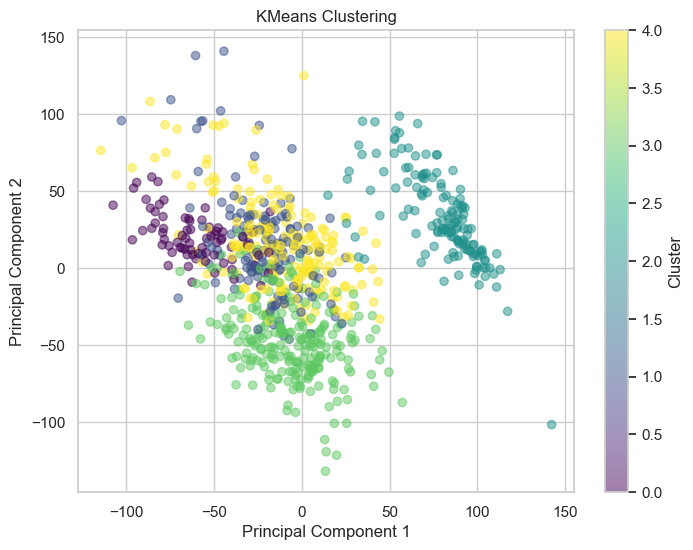

In [24]:
# Drop the class column for clustering
df_x = df.drop(columns=['Class'])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_x)

# Apply PCA for dimensionality reduction (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Visualize the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('KMeans Clustering')
plt.colorbar(label='Cluster')
plt.show()

## Model Training and Evaluation
We will now train various machine learning models to classify cancer subtypes. Each model will be evaluated using a cross-validation approach to ensure the robustness of our findings.


### Train and Evaluate Decision Tree Models (with 3-fold CV)

In [25]:
results = {}

In [26]:
def plot_metrics(accuracies, balanced_accuracies, precisions, recalls, f1_scores):
    folds = range(1, len(accuracies) + 1)
    plt.figure(figsize=(12, 8))
    
    plt.plot(folds, accuracies, label='Accuracy', marker='o')
    plt.plot(folds, balanced_accuracies, label='Balanced Accuracy', marker='o')
    plt.plot(folds, precisions, label='Precision', marker='o')
    plt.plot(folds, recalls, label='Recall', marker='o')
    plt.plot(folds, f1_scores, label='F1 Score', marker='o')

    plt.title('Evaluation Metrics per Fold')
    plt.xlabel('Fold Number')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [27]:
def plot_feature_importance(importances, feature_names):
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(12, 6))
    plt.title('Feature Importances')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.show()

In [28]:
label_encoder = LabelEncoder()


def train_model(model):
    # Split data into features and target
    X = df.drop(columns=['Class'])
    y = df['Class']
    y = label_encoder.fit_transform(y)


    # Initialize evaluation metrics lists
    accuracies = []
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    # Initialize KFold cross-validation
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    

    # Iterate over each fold of cross-validation
    for train_index, test_index in kf.split(X):
        # Split data into train and test sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        # Predict on the testing data
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Calculate evaluation metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred, average='weighted'))
        recalls.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        

    # Calculate average evaluation metrics
    avg_accuracy = sum(accuracies) / len(accuracies)
    avg_balanced_accuracy = sum(balanced_accuracies) / len(balanced_accuracies)
    avg_precision = sum(precisions) / len(precisions)
    avg_recall = sum(recalls) / len(recalls)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    # Print summary of model performance
    plot_metrics(accuracies, balanced_accuracies, precisions, recalls, f1_scores)
    print("Average Accuracy:", avg_accuracy)
    print("Average Balanced Accuracy:", avg_balanced_accuracy)
    print("Average Precision:", avg_precision)
    print("Average Recall:", avg_recall)
    print("Average F1 Score:", avg_f1)

    metrics = {
        'Accuracy': sum(accuracies) / len(accuracies),
        'Balanced Accuracy': sum(balanced_accuracies) / len(balanced_accuracies),
        'Precision': sum(precisions) / len(precisions),
        'Recall': sum(recalls) / len(recalls),
        'F1 Score': sum(f1_scores) / len(f1_scores)
    }

    return metrics

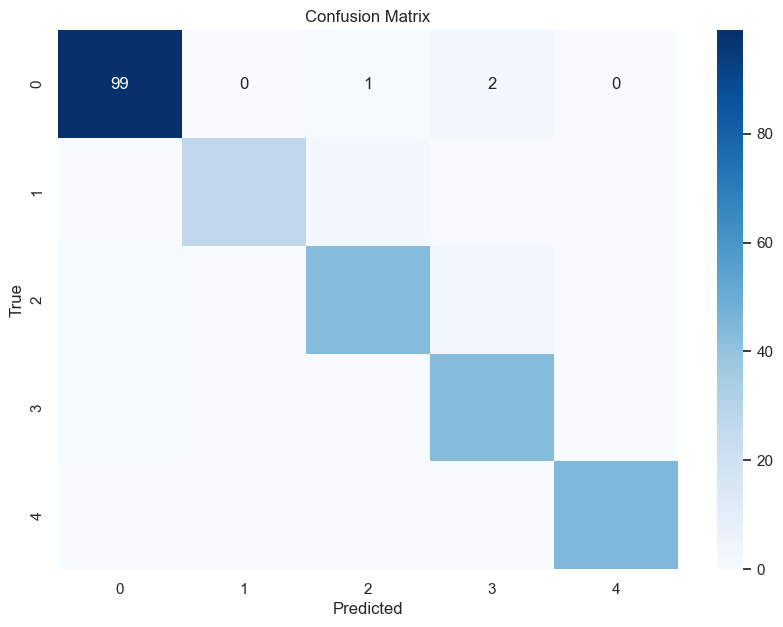

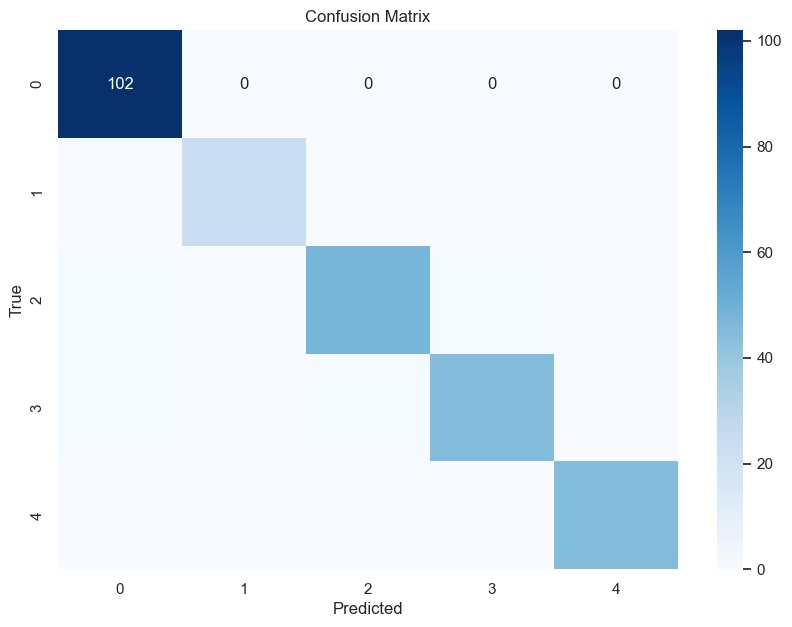

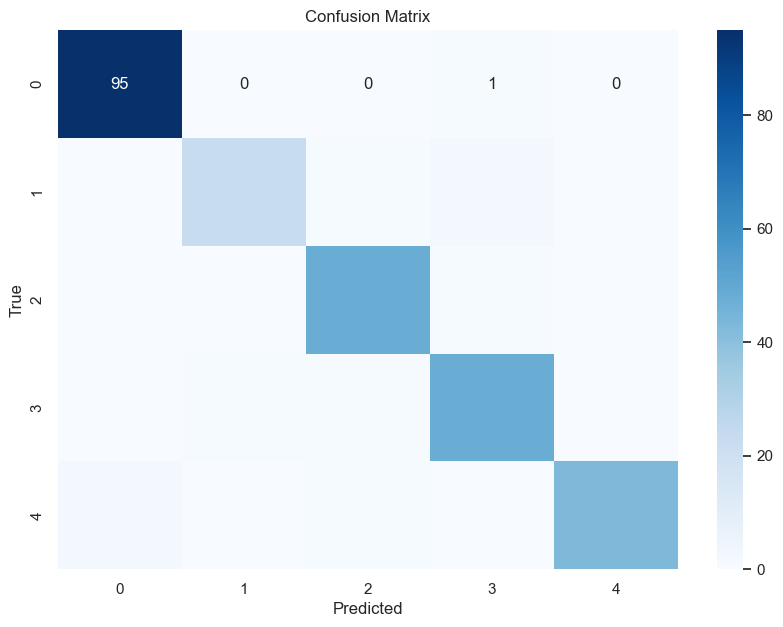

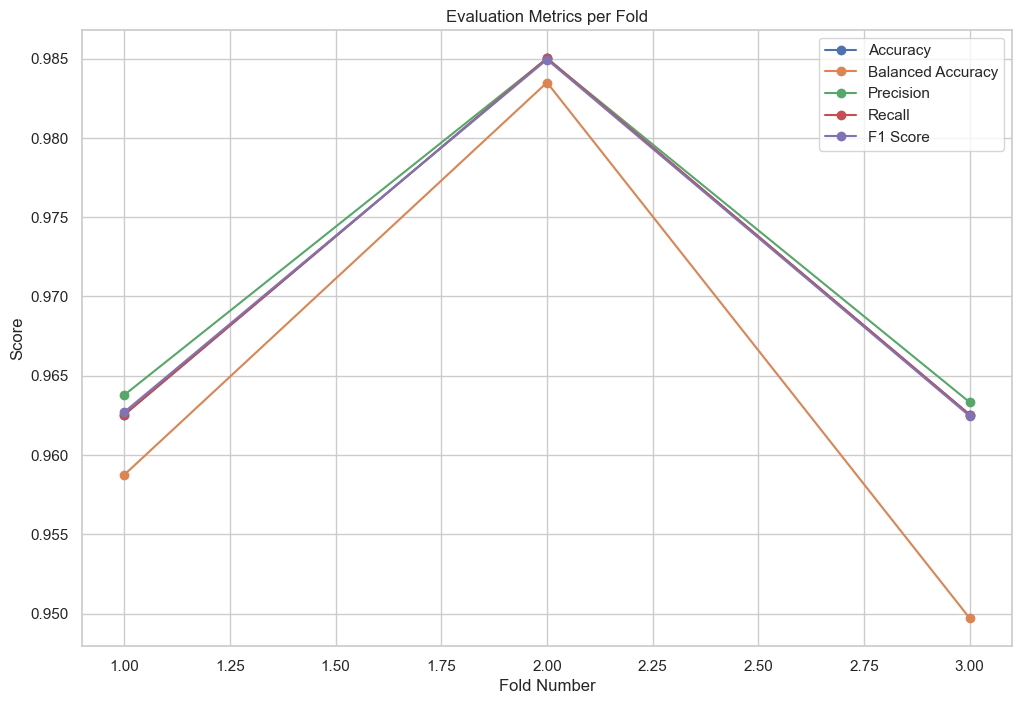

Average Accuracy: 0.9700374531835205
Average Balanced Accuracy: 0.9639872689490963
Average Precision: 0.9707075405442737
Average Recall: 0.9700374531835205
Average F1 Score: 0.97003649533108


In [29]:
# Train a decision tree model
model = DecisionTreeClassifier()
results['Decision Tree'] = train_model(model)

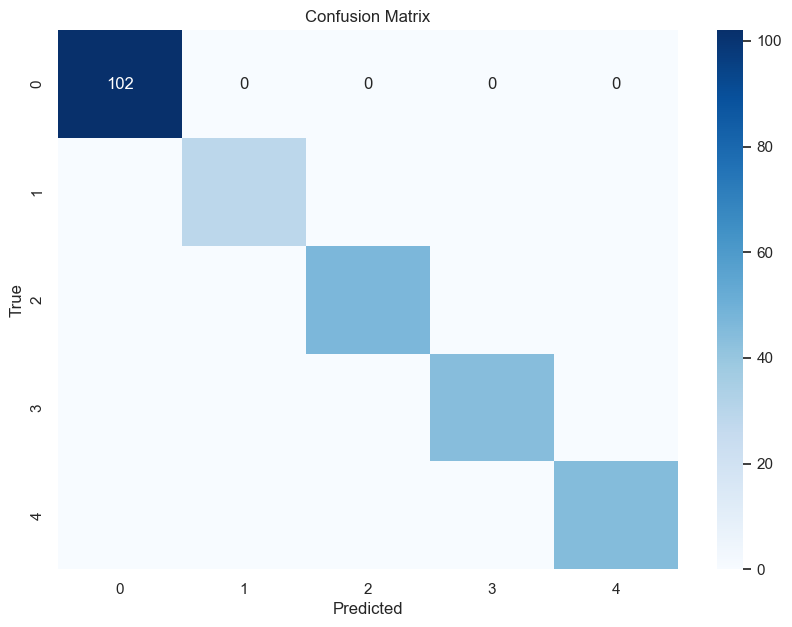

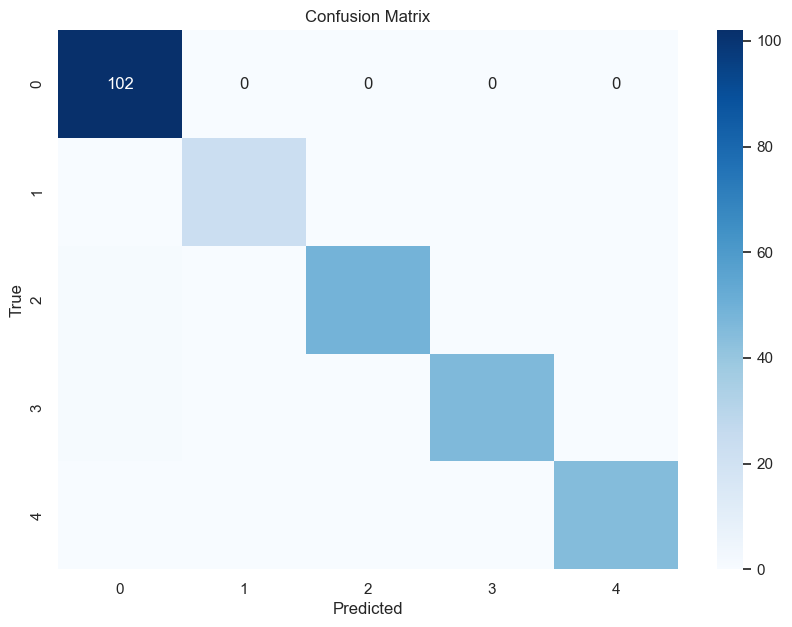

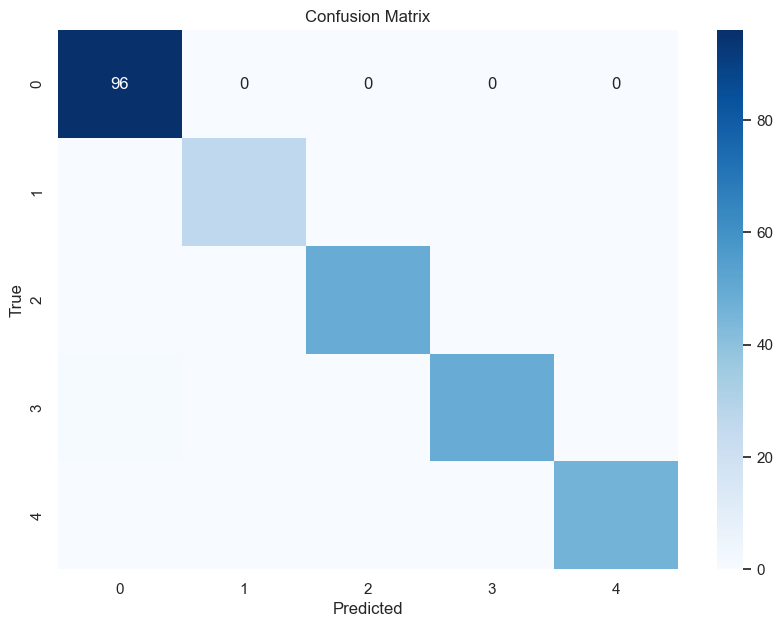

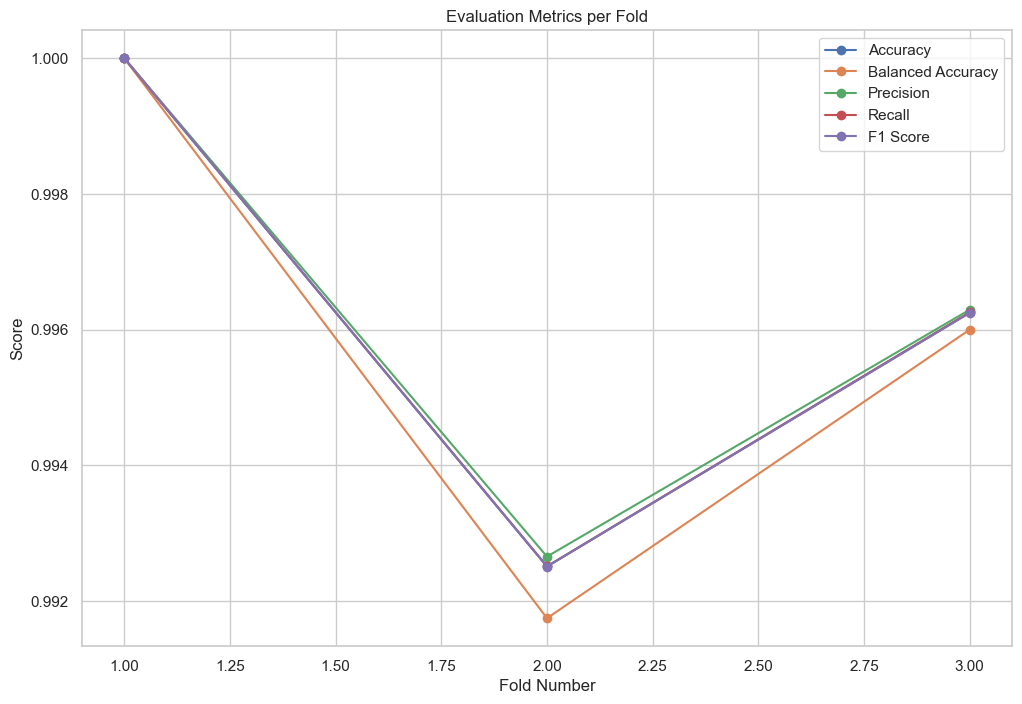

Average Accuracy: 0.99625468164794
Average Balanced Accuracy: 0.9959148936170212
Average Precision: 0.9963155690596904
Average Recall: 0.99625468164794
Average F1 Score: 0.9962507141788416


In [30]:
# Train a random forest model
model = RandomForestClassifier()
results['Random Forest'] = train_model(model)

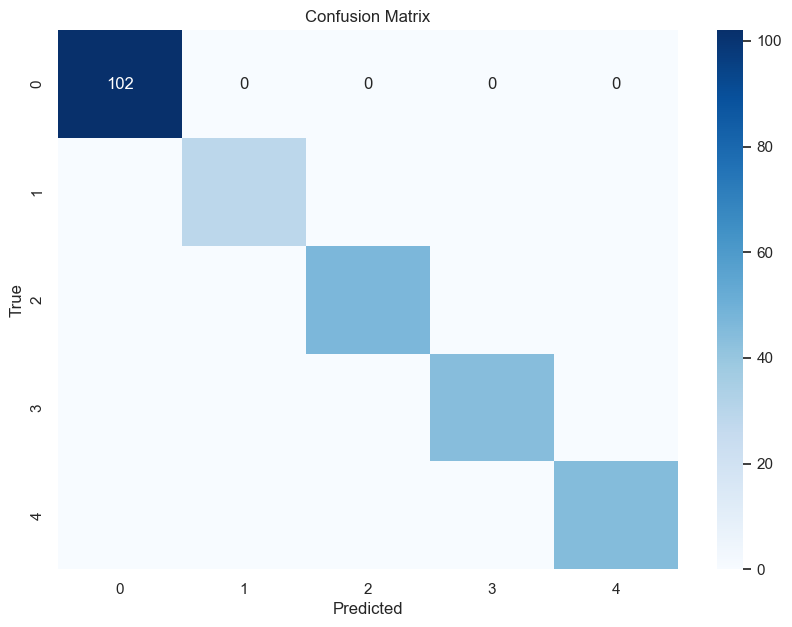

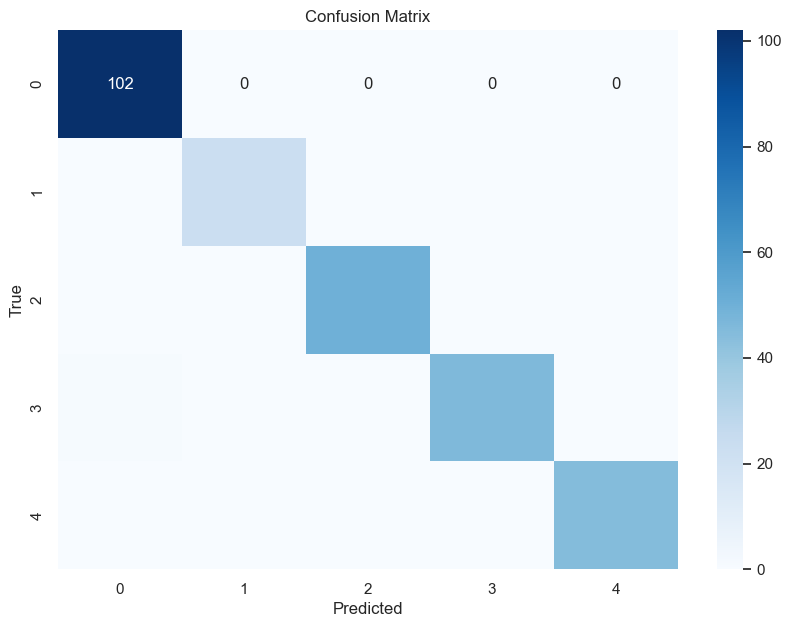

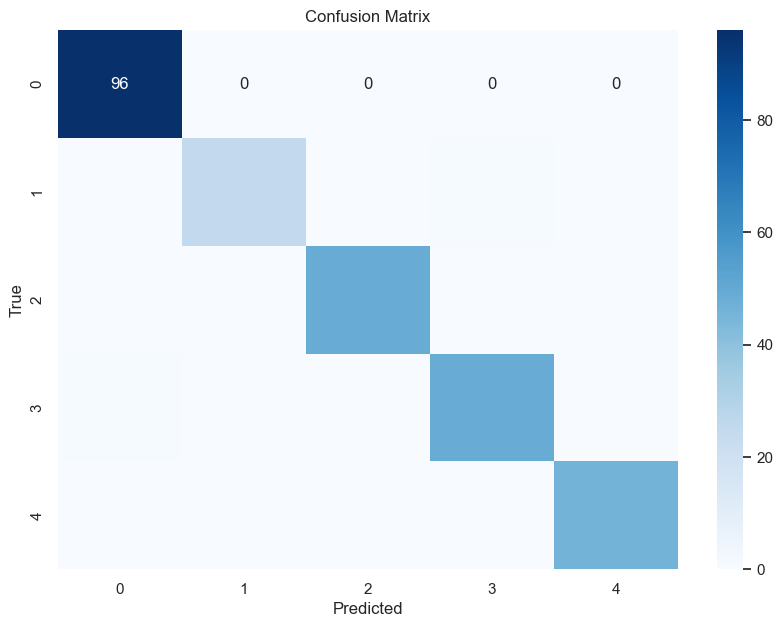

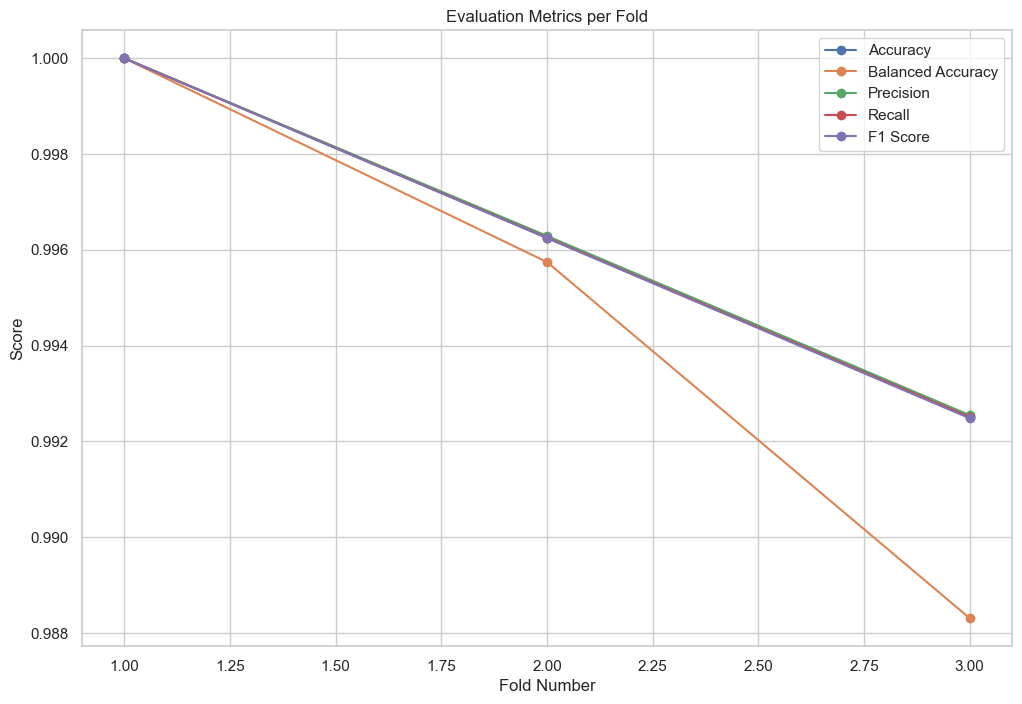

Average Accuracy: 0.99625468164794
Average Balanced Accuracy: 0.9946841243862522
Average Precision: 0.9962796729291069
Average Recall: 0.99625468164794
Average F1 Score: 0.9962420092787899


In [31]:
model = SVC(probability=True, random_state=42)
results['SVM'] = train_model(model)

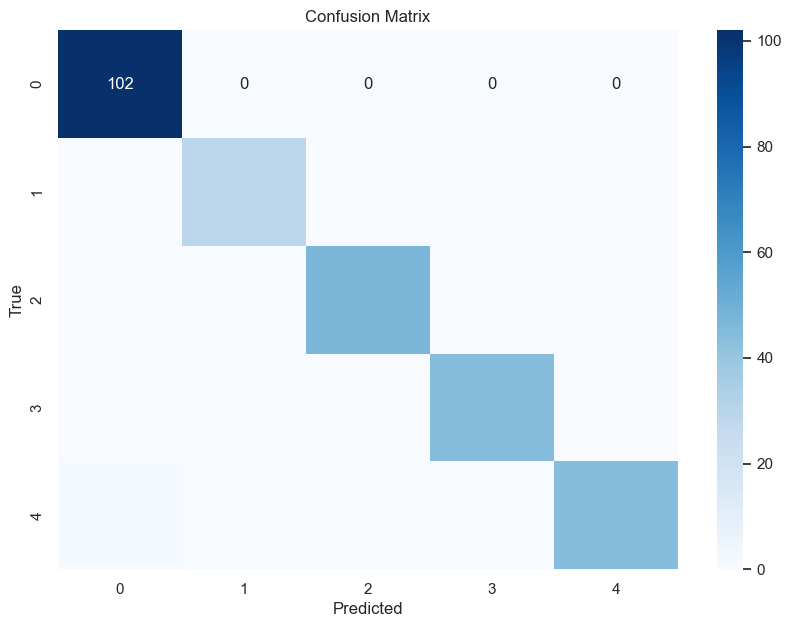

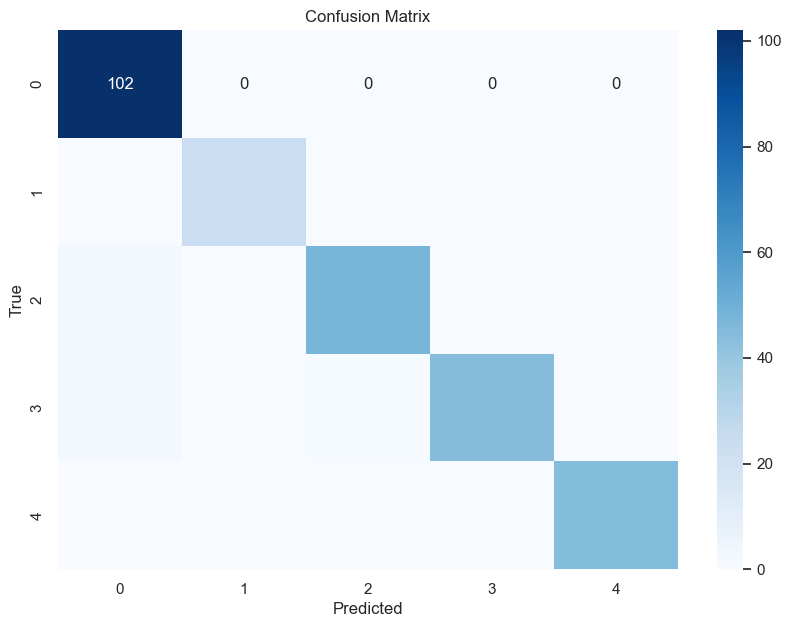

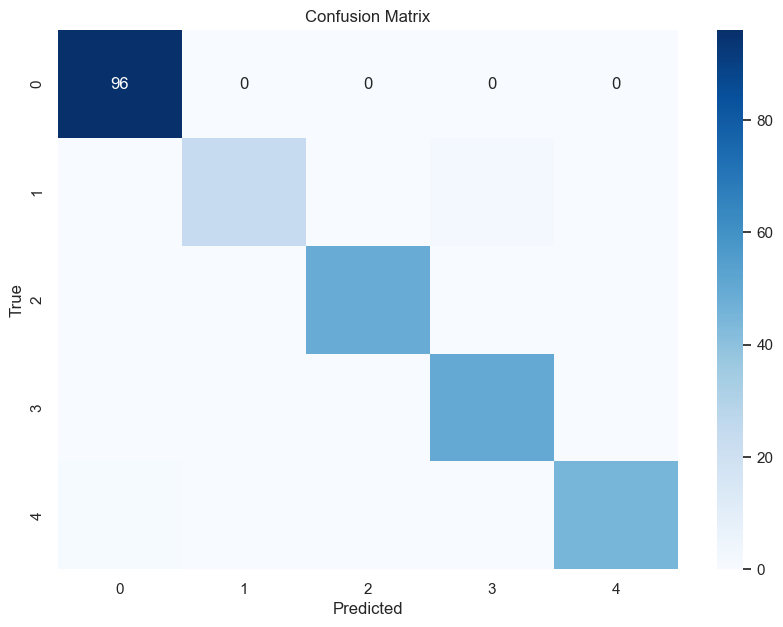

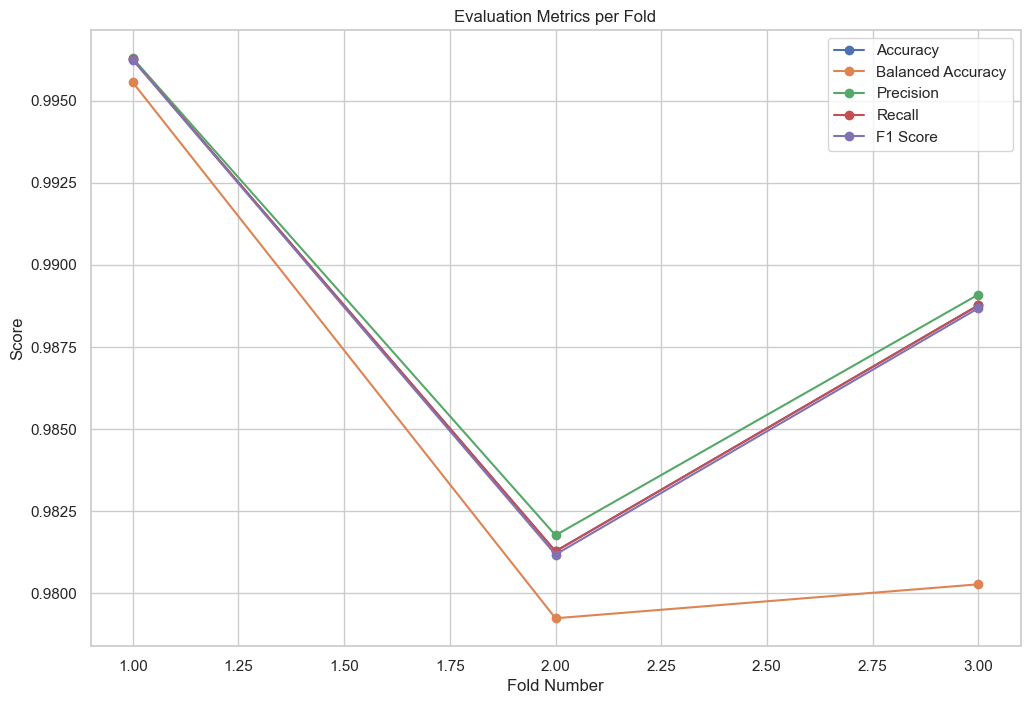

Average Accuracy: 0.9887640449438203
Average Balanced Accuracy: 0.9850190522123917
Average Precision: 0.9890480353634192
Average Recall: 0.9887640449438203
Average F1 Score: 0.9886983577177771


In [32]:
XGBoost = xgb.XGBClassifier(objective = 'multi:softprob')
results['XGBoost'] = train_model(XGBoost)


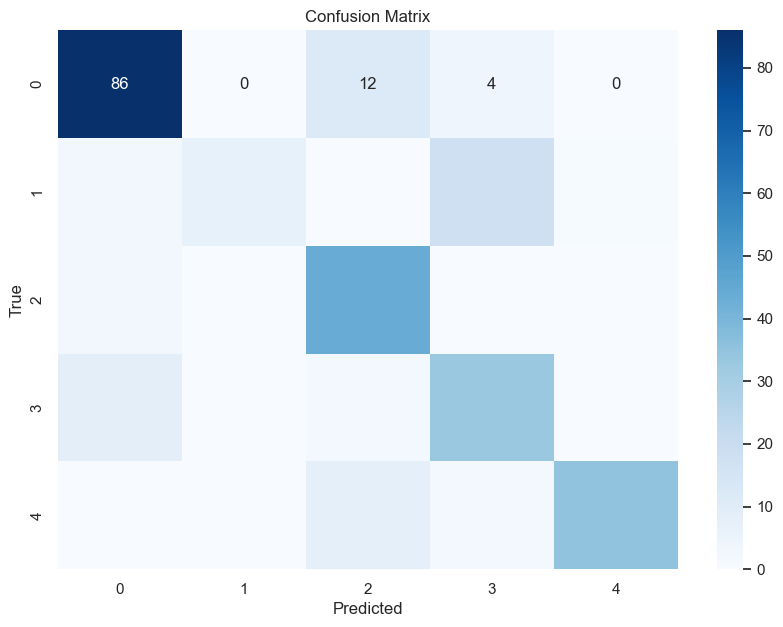

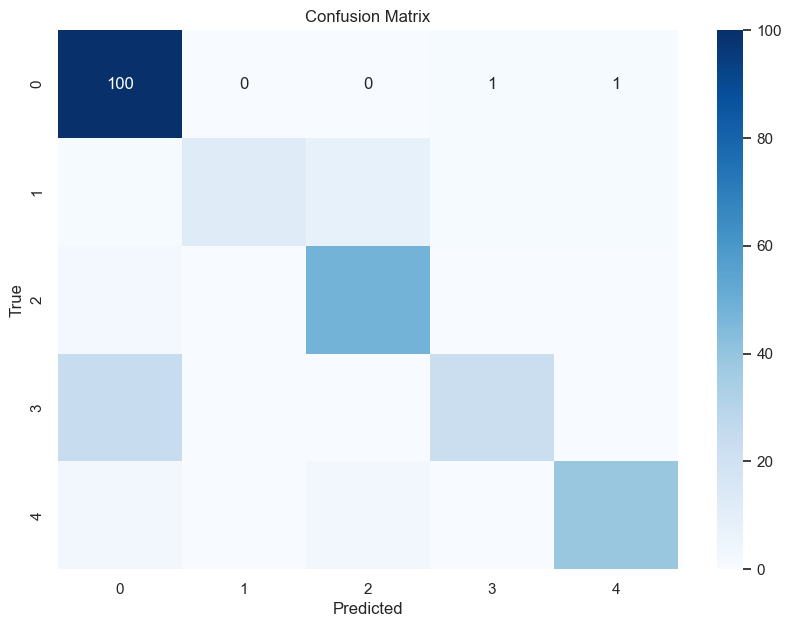

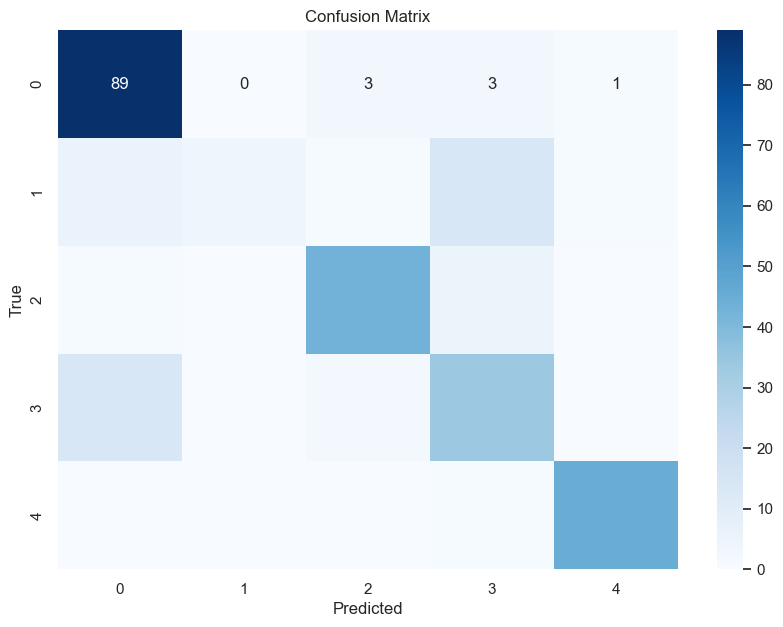

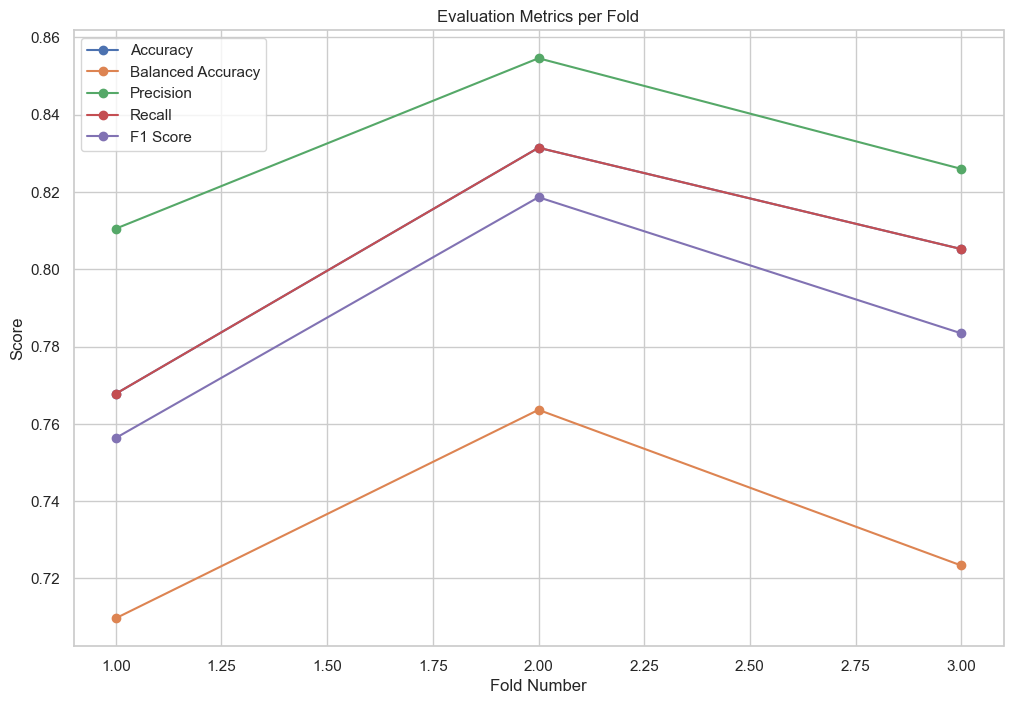

Average Accuracy: 0.801498127340824
Average Balanced Accuracy: 0.7322243726023497
Average Precision: 0.8303779365444616
Average Recall: 0.801498127340824
Average F1 Score: 0.786144904275639


In [33]:
naive_bayes_model = GaussianNB()
results['Naive Bayes'] = train_model(naive_bayes_model)


## Model Comparison
Finally, compare all trained models using different evaluation metrics. This step will help us identify the most effective model for predicting cancer subtypes based on genomic data.


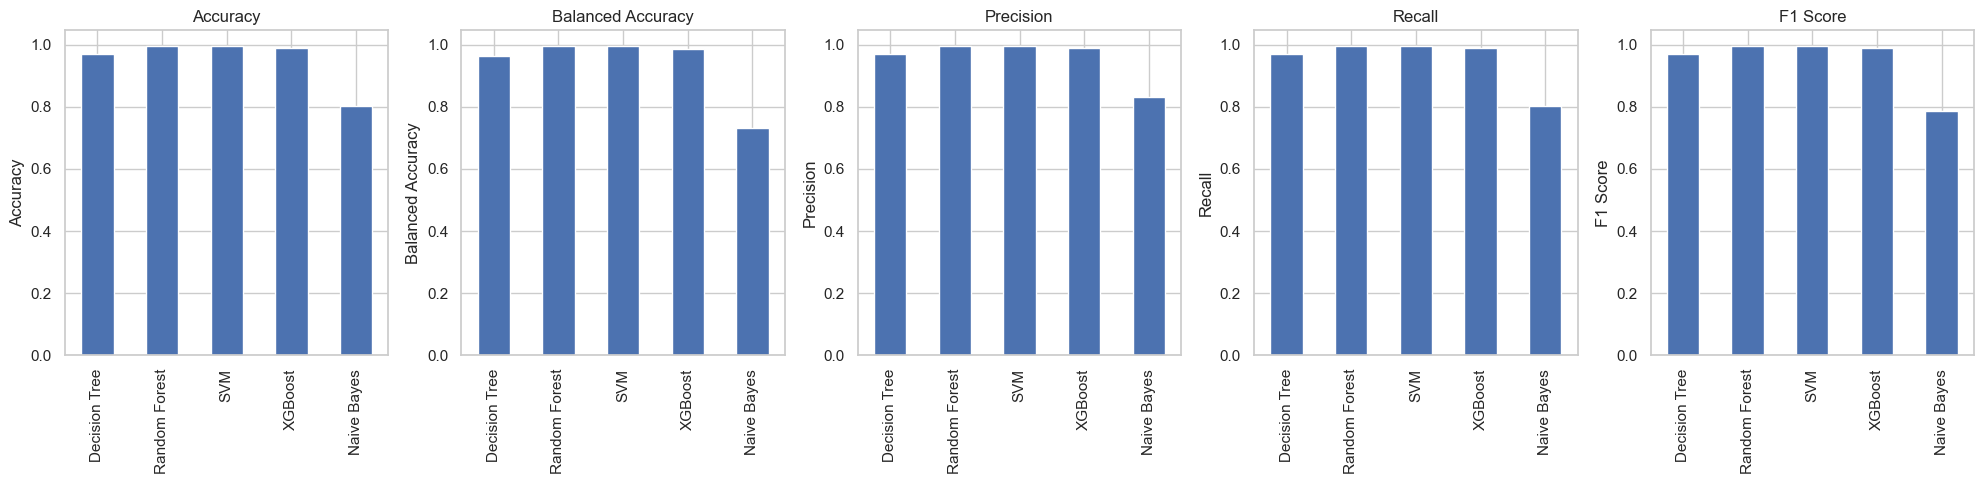

In [34]:
results_df = pd.DataFrame(results).T
metrics = results_df.columns
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 5))

for i, metric in enumerate(metrics):
    results_df[metric].plot(kind='bar', ax=axes[i], title=metric)
    axes[i].set_ylabel(metric)

plt.tight_layout()
plt.show()

## Conclusion

This project explored the application of machine learning techniques to the task of classifying cancer subtypes based on genomic data. The process involved several key steps, from data collection and preprocessing to model training and evaluation.

### Key Observations:
- **Data Preparation**: The genomic data was meticulously prepared through processes such as standardization and PCA for dimensionality reduction, ensuring that the models had the best possible representation of the underlying patterns.
- **Modeling**: A range of models, including Decision Trees, Random Forests, Support Vector Machines, Gradient Boosting, and Naive Bayes, were trained and evaluated. This diverse set of models allowed for a comprehensive analysis of different approaches to the classification problem.
- **Model Performance**: The evaluation revealed distinct differences in performance across models, with ensemble methods like Random Forest and Gradient Boosting showing strong overall metrics. Model evaluation was rigorously conducted using a 3-fold cross-validation method, enhancing the reliability of the performance metrics.

### Concluding Remarks:
- The use of multiple machine learning models provided a broad perspective on the predictive capabilities achievable with genomic data. The differences in performance across models highlighted the importance of model selection based on specific characteristics of the data.
- Decision Tree and Random Forest models, in particular, demonstrated significant promise, potentially due to their ability to handle the complex, non-linear relationships in high-dimensional genomic data.
- This analysis underscores the potential of machine learning in enhancing our understanding and classification of cancer subtypes, paving the way for more targeted and effective treatment strategies.

This project not only advances our understanding of genomic data application but also sets the stage for future research that could explore more complex models or deeper integration of machine learning with genomic data analysis.


## Glossary

- **Genomic Data**: Information derived from an organism's DNA. In the context of this project, it refers to the data obtained from cancer tissues used to identify specific cancer subtypes.

- **PCA (Principal Component Analysis)**: A statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.

- **Standardization**: The process of rescaling the features of data so that they have a mean of zero and a standard deviation of one. This is commonly performed before applying techniques like PCA.

- **K-Fold Cross-Validation**: A model validation technique used to evaluate how the results of a statistical analysis will generalize to an independent data set. It involves dividing the data into 'k' subsets and repeatedly training the model on 'k-1' subsets while using the remaining subset for validation.

- **Decision Tree**: A decision support tool that uses a tree-like model of decisions and their possible consequences. It is one of the predictive modeling approaches used in statistics, data mining, and machine learning.

- **Random Forest**: An ensemble learning method for classification, regression, and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees.

- **Support Vector Machines (SVM)**: A set of supervised learning methods used for classification, regression, and outliers detection.

- **Gradient Boosting**: A machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

- **Naive Bayes**: A simple probabilistic classifier based on applying Bayes' theorem with strong (naive) independence assumptions between the features.

- **Feature Engineering**: The process of using domain knowledge to select, modify, or create new features from raw data to increase the predictive power of the learning algorithms.

- **Ensemble Methods**: Techniques that create multiple models and then combine them to produce improved results. Common examples include Random Forest and Gradient Boosting.

- **Outlier Detection**: The identification of rare items, events, or observations which raise suspicions by differing significantly from the majority of the data.
